Author: Pavan Kumar Bondalapati<br>
Email: pb7ak@virginia.edu<br>
Class: DS 5001<br>
Date: May 11, 2021<br>

In [1]:
# Code is adapted from Raf Alvarado
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

In [2]:
ngram_range = [1, 2]
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 10

In [3]:
OHCO = ['book_num', 'fable_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
FABLES = OHCO[:2]
BOOKS = OHCO[:1]
BAG = PARAS

In [4]:
LIB = pd.read_csv('data_out/LIB.csv').set_index('book_num')
VOCAB = pd.read_csv('data_out/VOCAB.csv',  na_filter=False).set_index('term_str')
TOKENS = pd.read_csv('data_out/TOKEN.csv').set_index(OHCO)
LABELS = ['book_num']

In [5]:
narrs = ['The Divine Comedy', 
         'The Avenging Gods', 
         'The Pathos of Love', 
         'Rome and the Deified Ruler']
counts = [2-1+1, 6-3+1, 11-7+1, 15-12+1]
narratives = [n for n, c in zip(narrs, counts) for i in range(c)]
LIB['narrative'] = narratives

In [6]:
TOKENS

pos_tuple  pos  \
book_num fable_num para_num sent_num token_num                            
1        1         0        0        0              ('God', 'NNP')  NNP   
                                     1          ('reduces', 'VBZ')  VBZ   
                                     2            ('Chaos', 'NNP')  NNP   
                                     3              ('into', 'IN')   IN   
                                     4             ('order', 'NN')   NN   
...                                                            ...  ...   
15       5         21       9        19               ('at', 'IN')   IN   
                                     20             ('what', 'WP')   WP   
                                     21             ('time', 'NN')   NN   
                   22       0        0               ('THE', 'DT')   DT   
                                     1               ('END', 'NN')   NN   

                                               token_str term_str  
book_num fable_num para_num sent_num token_num                     
1        1         0        0        0               God      god  
                                     1           reduces  reduces  
                                     2             Chaos    chaos  
                                     3              into     into  
                                     4             order    order  
...                                                  ...      ...  
15       5         21       9        19               at       at  
                                     20             what     what  
                                     21             time     time  
                   22       0        0               THE      the  
                                     1               END      end  

[276849 rows x 4 columns]

In [7]:
# Create DOCS
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG)\
    .apply(lambda x: ' '.join(x.token_str))\
    .to_frame()\
    .rename(columns={0:'doc_str'})

In [8]:
DOCS = DOCS.join(LIB[['narrative']])

In [9]:
# Create Vector Space
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names()

In [10]:
# Generate Model
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [11]:
# THETA
THETA = pd.DataFrame(lda_engine.fit_transform(count_model), index=DOCS.index)
THETA.columns.name = 'topic_id'

In [12]:
# PHI
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [13]:
# Create TOPICS
TOPICS = PHI.stack().to_frame().rename(columns={0:'topic_weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
        x.sort_values('topic_weight', ascending=False)\
               .head(n_top_terms)\
               .reset_index()\
               .drop('topic_id',1)['term_str'])
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ', '.join(x[:n_top_terms]), 1)
TOPICS['doc_weight_sum'] = THETA.sum()

In [14]:
THETA

topic_id                           0         1         2         3         4   \
book_num fable_num para_num                                                     
1        1         0         0.005000  0.005000  0.005000  0.005000  0.005000   
                   1         0.000556  0.000556  0.000556  0.000556  0.000556   
                   2         0.000758  0.000758  0.000758  0.000758  0.000758   
                   3         0.003125  0.003125  0.003125  0.003125  0.003125   
                   4         0.001923  0.001923  0.001923  0.001923  0.001923   
...                               ...       ...       ...       ...       ...   
15       5         18        0.012500  0.012500  0.012500  0.012500  0.012500   
                   19        0.001087  0.001087  0.001087  0.001087  0.001087   
                   20        0.000694  0.000694  0.000694  0.000694  0.000694   
                   21        0.000455  0.000455  0.000455  0.000455  0.000455   
                   22        0.012500  0.012500  0.012500  0.012500  0.012500   

topic_id                           5         6         7         8         9   \
book_num fable_num para_num                                                     
1        1         0         0.005000  0.005000  0.005000  0.005000  0.005000   
                   1         0.000556  0.000556  0.000556  0.000556  0.000556   
                   2         0.000758  0.000758  0.000758  0.000758  0.000758   
                   3         0.003125  0.003125  0.003125  0.003125  0.003125   
                   4         0.001923  0.001923  0.001923  0.001923  0.001923   
...                               ...       ...       ...       ...       ...   
15       5         18        0.012500  0.012500  0.012500  0.012500  0.012500   
                   19        0.001087  0.001087  0.001087  0.001087  0.001087   
                   20        0.000694  0.687566  0.000694  0.000694  0.000694   
                   21        0.000455  0.000455  0.000455  0.000455  0.000455   
                   22        0.012500  0.012500  0.012500  0.012500  0.012500   

topic_id                     ...        30        31        32        33  \
book_num fable_num para_num  ...                                           
1        1         0         ...  0.005000  0.005000  0.005000  0.005000   
                   1         ...  0.000556  0.000556  0.000556  0.120226   
                   2         ...  0.000758  0.000758  0.000758  0.000758   
                   3         ...  0.003125  0.003125  0.003125  0.003125   
                   4         ...  0.001923  0.001923  0.001923  0.001923   
...                          ...       ...       ...       ...       ...   
15       5         18        ...  0.012500  0.012500  0.012500  0.012500   
                   19        ...  0.001087  0.001087  0.001087  0.001087   
                   20        ...  0.000694  0.000694  0.000694  0.000694   
                   21        ...  0.000455  0.000455  0.000455  0.000455   
                   22        ...  0.012500  0.012500  0.012500  0.012500   

topic_id                           34        35        36        37        38  \
book_num fable_num para_num                                                     
1        1         0         0.005000  0.005000  0.005000  0.005000  0.005000   
                   1         0.000556  0.000556  0.000556  0.000556  0.000556   
                   2         0.000758  0.000758  0.000758  0.000758  0.970455   
                   3         0.003125  0.003125  0.003125  0.003125  0.003125   
                   4         0.001923  0.001923  0.001923  0.925000  0.001923   
...                               ...       ...       ...       ...       ...   
15       5         18        0.012500  0.012500  0.012500  0.012500  0.512500   
                   19        0.001087  0.001087  0.001087  0.001087  0.001087   
                   20        0.000694  0.000694  0.000694  0.000694  0.000694   
            

In [15]:
# Explore Topics by Narrative
topic_cols = [t for t in range(n_topics)]
NARRATIVE = THETA.join(LIB, on='book_num')\
    .reset_index().set_index(['narrative']+BAG)\
    .groupby('narrative')[topic_cols].mean()\
    .T                                            
NARRATIVE.index.name = 'topic_id'
NARRATIVE['label'] = TOPICS['label']

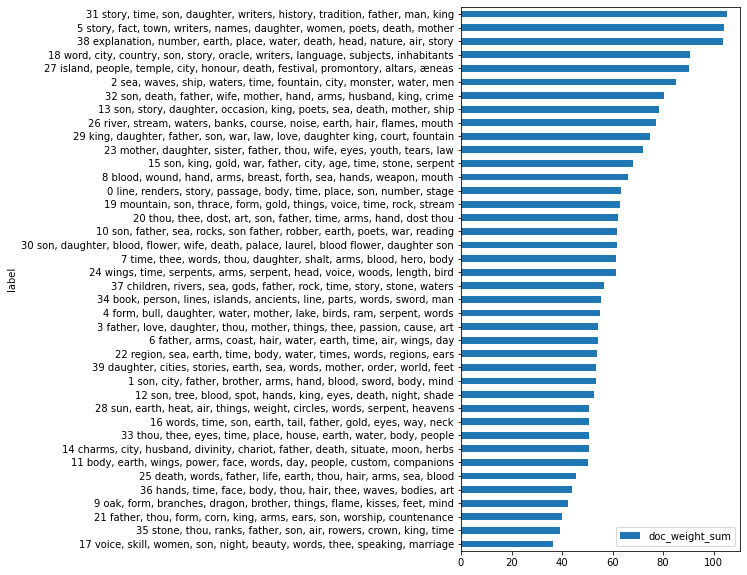

In [16]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/4));

In [17]:
narrs = ['The Divine Comedy', 
         'The Avenging Gods', 
         'The Pathos of Love', 
         'Rome and the Deified Ruler']

In [18]:
NARRATIVE[['The Divine Comedy', 'label']].sort_values('The Divine Comedy', ascending=False).head(5)

narrative,The Divine Comedy,label
topic_id,,
31,0.061704,"31 story, time, son, daughter, writers, histor..."
26,0.061236,"26 river, stream, waters, banks, course, noise..."
38,0.052203,"38 explanation, number, earth, place, water, d..."
28,0.042508,"28 sun, earth, heat, air, things, weight, circ..."
19,0.037464,"19 mountain, son, thrace, form, gold, things, ..."


In [19]:
NARRATIVE[['The Avenging Gods', 'label']].sort_values('The Avenging Gods', ascending=False).head(5)

narrative,The Avenging Gods,label
topic_id,,
5,0.045470,"5 story, fact, town, writers, names, daughter,..."
18,0.041002,"18 word, city, country, son, story, oracle, wr..."
23,0.040180,"23 mother, daughter, sister, father, thou, wif..."
38,0.038035,"38 explanation, number, earth, place, water, d..."
31,0.036340,"31 story, time, son, daughter, writers, histor..."


In [20]:
NARRATIVE[['The Pathos of Love', 'label']].sort_values('The Pathos of Love', ascending=False).head(5)

narrative,The Pathos of Love,label
topic_id,,
5,0.046227,"5 story, fact, town, writers, names, daughter,..."
32,0.043488,"32 son, death, father, wife, mother, hand, arm..."
2,0.041072,"2 sea, waves, ship, waters, time, fountain, ci..."
38,0.040839,"38 explanation, number, earth, place, water, d..."
27,0.036916,"27 island, people, temple, city, honour, death..."


In [21]:
NARRATIVE[['Rome and the Deified Ruler', 'label']].sort_values('Rome and the Deified Ruler', ascending=False).head(5)

narrative,Rome and the Deified Ruler,label
topic_id,,
27,0.049446,"27 island, people, temple, city, honour, death..."
31,0.041895,"31 story, time, son, daughter, writers, histor..."
18,0.038158,"18 word, city, country, son, story, oracle, wr..."
38,0.037264,"38 explanation, number, earth, place, water, d..."
30,0.036633,"30 son, daughter, blood, flower, wife, death, ..."
